In [1]:
import sys
sys.path.insert(0, "../code/data")
sys.path.insert(0, "../code/utils")

import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import cm
from tqdm.notebook import trange, tqdm
from functions_markov import fillmarkov, compute_P_0, normalize_matrix, generate_chain, compute_P0_inner_loop
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
import multiprocessing
import concurrent
import time
import random


In [3]:
def plot_P0(P0stat, T, ax, scale_text=15, color=None, param_name="a"):
    xv=np.concatenate(([1], np.arange(2, P0stat.shape[0], 2)))
    x_100=np.arange(100, P0stat.shape[0], 2)
    # plot only initial value and even values to remove oscillations
    y_100=P0stat[x_100]
    
    def exp_f(x, a, b):
        return a * np.power(x, b)
    popt, pcov = curve_fit(exp_f, x_100, y_100)
    y_pred=exp_f(x_100, *popt)
    
    #model_linreg = LinearRegression()
    #model_linreg.fit(x_100, y_100)
    #y_pred=model_linreg.predict(x_100)
    #coeff=model_linreg.coef_[0][0]
    r2_score=metrics.r2_score(y_100, y_pred)
  
    if np.any(color):
        ax.plot(xv, P0stat[xv], label=f"{param_name}={T}", color=color, linewidth=2)
    else:
        ax.plot(xv, P0stat[xv], label=f"{param_name}={T}", linewidth=2)
    if isinstance(T, float): T = np.round(T, 3)
    
    ax.plot(x_100, y_pred, 'k--', label="T={0}, slope={1:.3}, r2={2:.3}".format(T, popt[1], r2_score), linewidth=2)
    ax.legend(fontsize=scale_text)
    ax.tick_params(axis='both', which='major',labelsize=scale_text)
    try:
        ax.set_yscale('log')
        ax.set_xscale('log')
    except:
        print("not log scaled")
    
    ax.set_xlabel('∆t', fontsize=scale_text)
    ax.set_ylabel('P0(∆t)', fontsize=scale_text)
    ax.set_xlim(1, 1e4)
    ax.set_xticks([1, 10, 1e2, 1e3, 1e4])
    return popt[1]

#Relationship between T and slope
def plot_temp_vs_slope(t_range, coeffs):
    f,a = plt.subplots(1,1)
    a.plot(t_range, coeffs, marker='o')
    a.set_xlabel("Temperature")
    a.set_ylabel("Linear slope coeff")
    a.set_title("Relationship between T and slope")
    f.savefig(f"../plots/temperature_vs_slope.jpg", dpi=250)
    plt.show()
    
def compute_P0_multiprocess(executor, maxh, chain, tree_l):
    print("Computing P_0...")
    P0=np.zeros(maxh)
    P0stat=np.zeros(maxh)
    
    i_set = set(chain)
    futures = [executor.submit(compute_P0_inner_loop, i, P0, P0stat, chain, tree_l, maxh)
               for i in i_set]
    concurrent.futures.wait(futures)
    print(f"#futures: {len(futures)}")
    for future in futures:
        res = future.result()
        P0stat = P0stat + res
        
    P0stat[0]=1
    P0stat[1]=1
    return P0stat

In [4]:
#DEF VARS
dia=0
tree_levels=13 # 13
maxh=10000 # 10000
chain_length = 10000000 # 10000000
tree_l=2**tree_levels # number of leaves
markovm=np.zeros((tree_l,tree_l))
md=tree_levels
T_fixed=0.6


  0%|          | 0/6 [00:00<?, ?it/s]

Temp 0.5, chain_length: 1000000, Chain: 31, Pool 8
Computing P_0...
#futures: 32
P_0 computed in 5.25min
Temp 0.55, chain_length: 1000000, Chain: 31, Pool 8
Computing P_0...


KeyboardInterrupt: 

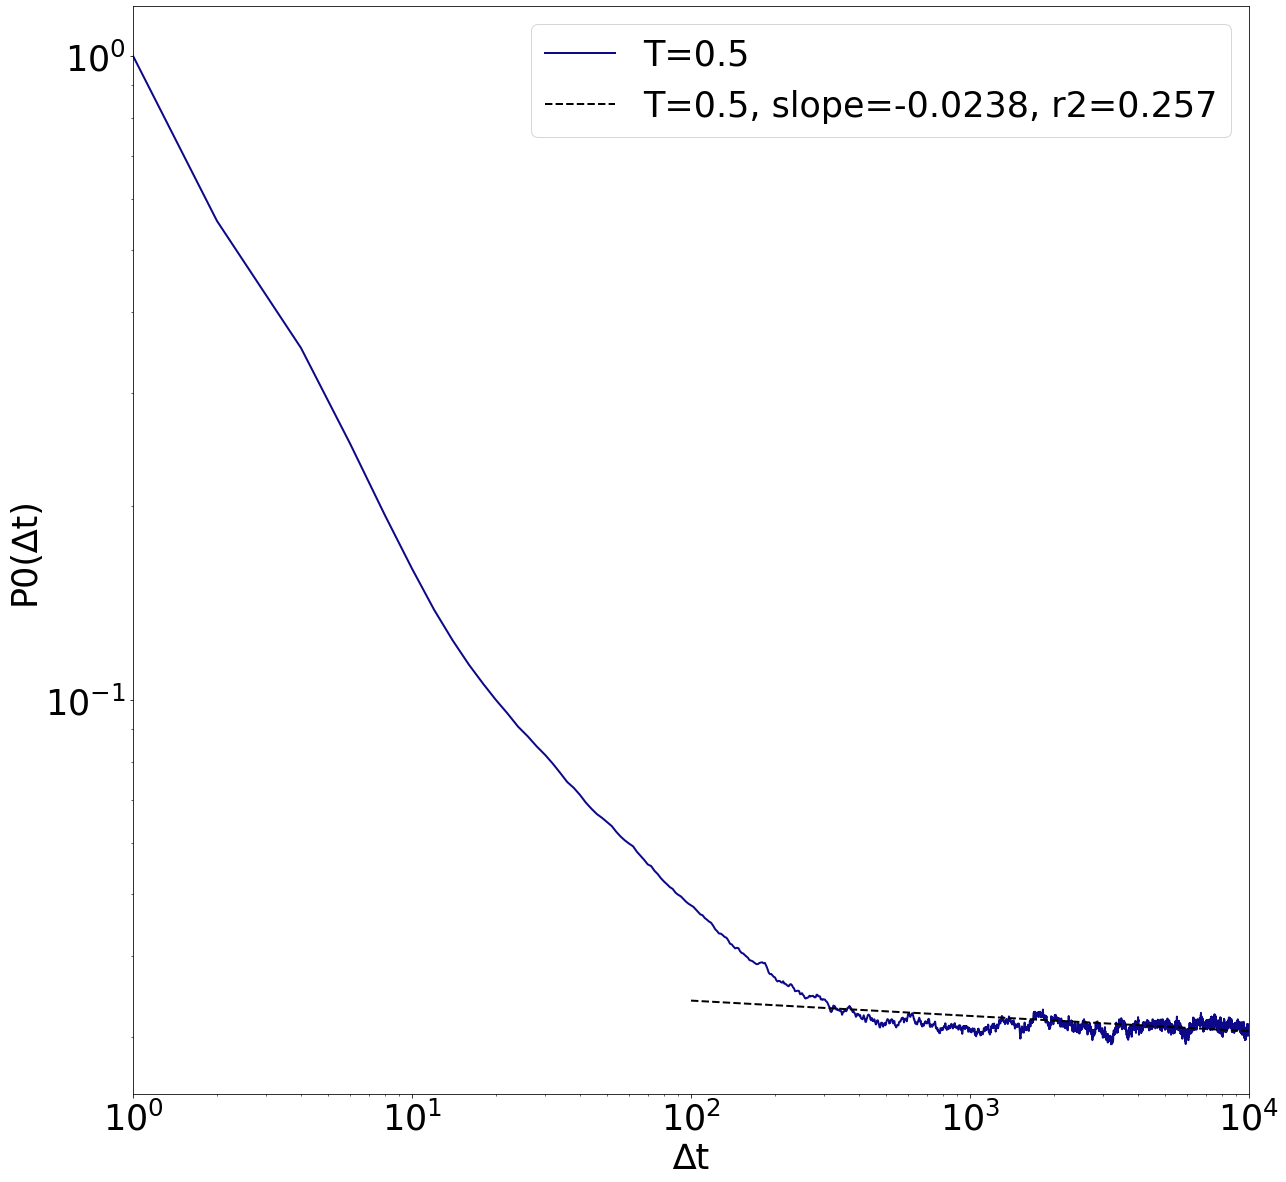

In [5]:
f2, a2 = plt.subplots(1,1)
f2.set_figheight(20)
f2.set_figwidth(20)
t_range = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
viridis = cm.get_cmap('plasma', len(t_range))
coeffs=[]
executor8 = concurrent.futures.ProcessPoolExecutor(8)

for i, T in tqdm(enumerate(t_range), total=len(t_range)):
    markovm=fillmarkov(markovm,0,0,tree_l,md)
    markovme=np.exp(-markovm/T)
    markovme = normalize_matrix(dia, tree_l, markovme)
    chain = generate_chain(markovme, chain_length, verbose=0)
    
    print(f"Temp {T}, chain_length: {len(chain)}, Chain: {np.max(chain)}, Pool {8}")
    start_time = time.time()
    if len(chain) >= 1e6:
        P0stat = compute_P0_multiprocess(executor8, maxh, chain, tree_l)
    else:
        _, P0stat = compute_P_0(maxh, tree_l, chain, verbose=0)
    end_time = time.time()
    print(f"P_0 computed in {(end_time-start_time)/60:.3}min")

    coeff=plot_P0(P0stat, T, a2, scale_text=35, color=viridis.colors[i], param_name="T")
    coeffs.append(coeff)
    f2.savefig(f"../plots/temp_plot_iter_{i}_clen_{len(chain)}.jpg")
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
f2.savefig(f"../plots/plots_P0_{current_time}_depth_{tree_levels}_clen_{chain_length}.jpg", dpi=200)
plt.show()
plot_temp_vs_slope(t_range, coeffs)


# Shuffled data

In [6]:
def shuffle_blocks_v2(chain, b_len):
    shuff_chain = chain.copy() #bc we modifiy in-place afterward
    blocks = [shuff_chain[i:i+b_len] for i in range(0,len(shuff_chain),b_len)]
    np.random.shuffle(blocks)
    shuff_chain[:] = [b for bs in blocks for b in bs]
    return shuff_chain

In [13]:
markovm=fillmarkov(markovm,0,0,tree_l,md)
markovme=np.exp(-markovm/T_fixed)
markovme = normalize_matrix(dia, tree_l, markovme)
# generate the markov chain
chain = generate_chain(markovme, chain_length, verbose=1)

Generating Markov chain...
Markov chain generated


Computing P_0...
#futures: 8192
Block length: 10
Computing P_0...
#futures: 8192
Block length: 100
Computing P_0...
#futures: 8192
Block length: 1000
Computing P_0...
#futures: 8192


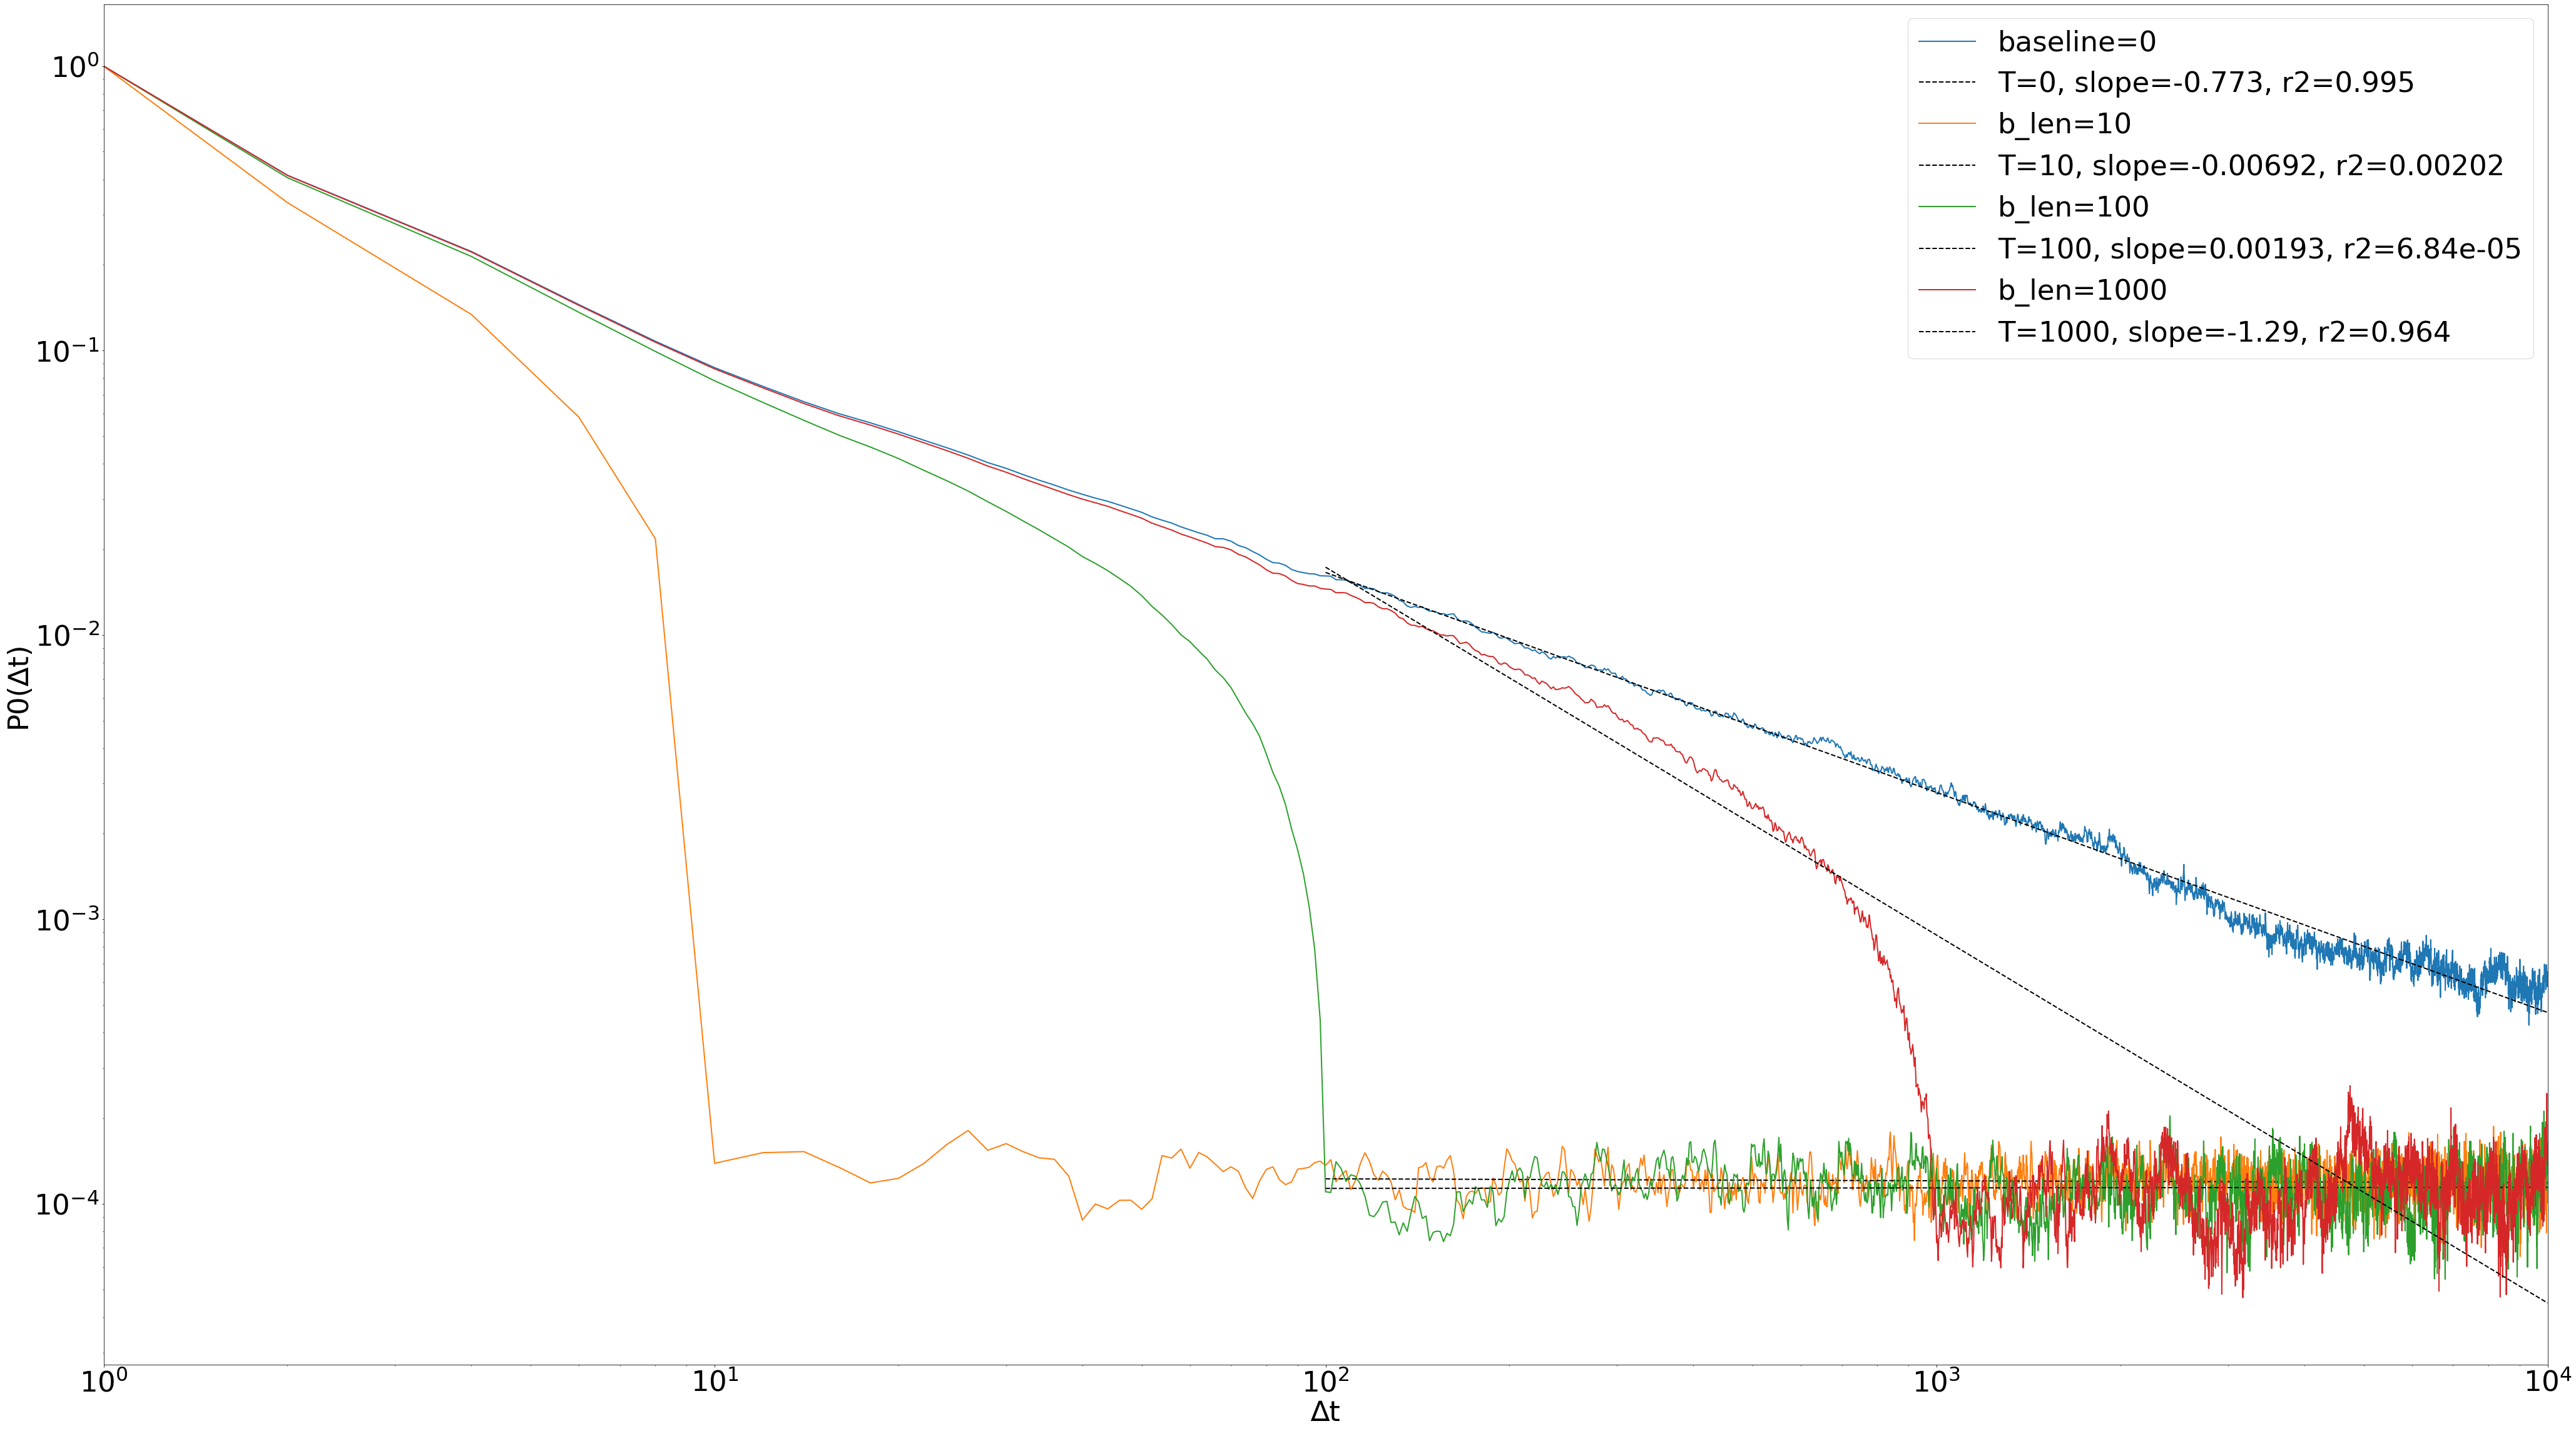

In [14]:
# shuffled data
blocklengths=[10, 100, 1000]
nbl=len(blocklengths)
f3, a3 = plt.subplots(1,1)
f3.set_figheight(40)
f3.set_figwidth(70)
executor8 = concurrent.futures.ProcessPoolExecutor(8)

#No shuffle baseline
if len(chain) >= 1e6:
    P0stat = compute_P0_multiprocess(executor8, maxh, chain, tree_l)
else:
    _, P0stat = compute_P_0(maxh, tree_l, chain, verbose=0)
plot_P0(P0stat, 0, a3, scale_text=45, param_name="baseline")
f3.savefig(f"../plots/temp_plot_no_shuffle_depth_{tree_levels}_clen_{chain_length}.jpg")

for bl in range(0, nbl):
    blength=blocklengths[bl]
    print(f'Block length: {blength}')
    shuffled_chain=shuffle_blocks_v2(chain, blength)
    
    if len(shuffled_chain) >= 1e6:
        P0stat = compute_P0_multiprocess(executor8, maxh, shuffled_chain, tree_l)
    else:
        _, P0stat = compute_P_0(maxh, tree_l, shuffled_chain, verbose=0)    
    plot_P0(P0stat, blength, a3, scale_text=45, param_name="b_len")
    f3.savefig(f"../plots/temp_plot_shuffled_blength_{blength}.jpg")
plt.show()

In [2]:
#DEF VARS
dia=0
chain_length = 1000000 # 10000000
T_fixed=0.4

In [6]:
for seed in np.arange(10):
    for tree_levels in [3,4,5,6,7,8,9,10]:
        tree_l=2**tree_levels
        random.seed(seed)
        markovm=np.zeros((tree_l,tree_l))

        markovm=fillmarkov(markovm,0,0,tree_l,tree_levels)
        markovme=np.exp(-markovm/T_fixed)
        markovme = normalize_matrix(dia, tree_l, markovme)
        # generate the markov chain
        chain = generate_chain(markovme, chain_length, verbose=1)
        np.save(f"../saved_chains/tree_levels{tree_levels:02d}_clen{chain_length:.1e}_seed{seed:}", np.array(chain))

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]

Generating Markov chain...


  0%|          | 0/999999 [00:00<?, ?it/s]